In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import ultraplot as plot 
import seaborn as sns
import colorcet as cc

import uproot
import mplhep as hep
import hist
import hist.intervals
import hist.plot

plot.rc['figure.facecolor'] = 'none'
plot.rc['savefig.facecolor'] = 'none'
plot.rc['legend.frameon'] = False
plot.rc['axes.autolimit_mode'] = 'data'

In [2]:
loader_formatted = {
    'nominal': 'Nominal reconstruction',
    'cheated_2d': 'Injected clustering',
    'cheated_vtx': 'Injected vertex',
    'cheated_vtxSelection': 'Injected vertex selection',
    'cheated_3d': 'Injected 3D matching',
    'cheated_nuH': r'Injected $\nu$-hierarchy',
    'cheated_mva': 'Injected track-score',
    'cheated_2d_vtx': 'Injected clustering + vertex',
    'cheated_2d_vtx_3d': 'Injected clustering + vertex + 3D matching',
    'cheated_2d_vtx_3d_nu': r'Injected clustering + vertex + 3D matching + $\nu$-hierarchy',
    'cheated_2d_vtx_3d_nu_mva': r'Injected clustering + vertex + 3D matching + $\nu$-hierarchy + track-score'
}

In [3]:

class Analysis:
    def __init__(self, data, binning, tree_bases=['reco_true_{}', 'reco_{}', 'true_{}']):
        self.binning = binning
        self.data = data

        self.reco_true_base_string, self.reco_base_string, self.true_base_string = tree_bases

    def efficiency(self, tree_name: str, variable: str = 'true_E'):

        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, true.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        true_values = true_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            efficiency = reco_true_values/true_values
            efficiency_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, true_values, 'efficiency'
            )
        
        return efficiency, efficiency_uncertainty
    
    def purity(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        reco_values = reco_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            purity = reco_true_values/reco_values
            purity_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, reco_values, 'efficiency'
            )
        
        return purity, purity_uncertainty

    def spectra(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        common = pd.merge(common.event, true.event, on='event')

        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        return reco_true_H, reco_H, true_H

class Component:
    def __init__(self, data, tree_base='{}'):
        self.data = data
        self.tree_base = tree_base

    def get(self, 
            stage1: str | list[str], 
            product: str | list[str], 
            binning, 
            product_thr: float | list[float] = -100,
            conditions: dict | None = None
           ):

        if not isinstance(stage1, list):
            stage1 = [stage1]

        if not isinstance(product, list):
            product = [product]

        if not isinstance(product_thr, list):
            product_thr = [product_thr] * len(product)
        

        if not isinstance(binning, list) and len(product) > 1:
            binning = [binning] * len(product)
        
        data = []
        hists = []
    
        for e in stage1:
            data.append(self.data[self.tree_base.format(e)].arrays(library='pd'))

        
        d0 = data[0]
        common = d0
        for i in range(1, len(data)):
            d = data[i]
            common = pd.merge(
                d0[(d0[product] > product_thr).all(axis=1)][['Evt', *product]], 
                d[(d[product] > product_thr).all(axis=1)][['Evt', *product]], 
                on='Evt', suffixes=('', '_more')
            )
            # print(common.keys())
            d0 = common

        return_data = []
        for d in data:
            if len(product) == 1:
                if conditions is not None:
                    for k in conditions:
                        d = d[d[k] == conditions[k]]
                hists.append(hist.Hist(binning).fill(d[d.Evt.isin(common.Evt)][product[0]].fillna(0).values))
            else:
                fill_data = [d[d.Evt.isin(common.Evt)][p].values for p in product]
                hists.append(hist.Hist(*binning).fill(*fill_data))
                return_data.append(d[d.Evt.isin(common.Evt)][['Evt', *product]])
            if False:
                print('ERROR: only 1D and 2D histograms are supported. The provided list of products exceed dimensionality: {}'.format(product))
            
        return hists, return_data
            
    def keys(self, stage1):
        return self.data[self.tree_base.format(stage1)].keys()


In [4]:
CCNp_muonAna = Component(data=uproot.open('CCNp_particleAna.root:muons'), tree_base='true_{}')
CCNp_protonAna = Component(data=uproot.open('CCNp_particleAna.root:protons'), tree_base='true_{}')

CCNp_muonAna.keys('nominal'), CCNp_protonAna.keys('nominal')

(['event',
  'chi2_mu',
  'chi2_proton',
  'length',
  'length_ratio',
  'vtxDist',
  'trackScore',
  'completeness',
  'purity',
  'pandoraPrimary',
  'Run',
  'Subrun',
  'Evt'],
 ['chi2_mu',
  'chi2_proton',
  'length',
  'length_ratio',
  'vtxDist',
  'trackScore',
  'completeness',
  'purity',
  'depEnergy',
  'pandoraPrimary',
  'Run',
  'Subrun',
  'Evt'])

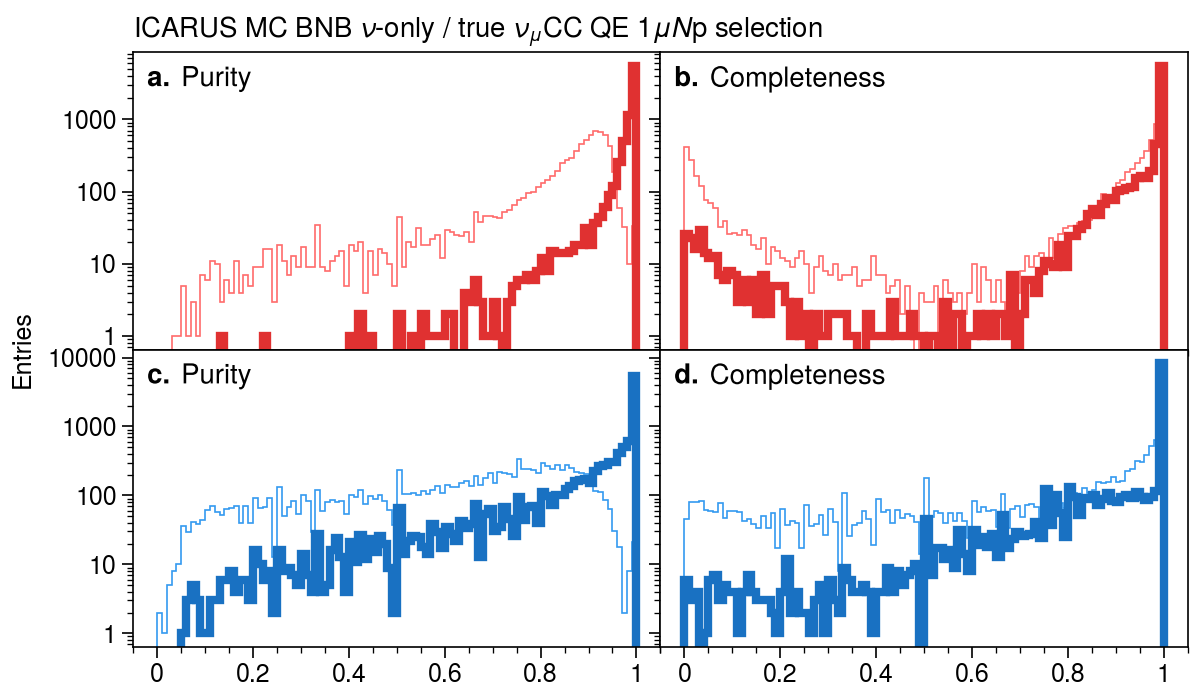

In [85]:
binning=hist.axis.Regular(100, 0, 1, flow=False)


fig, ax = plot.subplots(
    width=6, height=3.5, ncols=2, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ul',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

capitalise_title = {
    'purity': 'Purity',
    'completeness': 'Completeness'
}

# for axi, title in zip(ax, ['Purity', 'Completeness']*2):
#     axi.format(ultitle=title)

for idx, (loader, color) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'])):
    for jdx, var in enumerate(['purity', 'completeness']):

        (A,B), _ = loader.get(['nominal', 'cheated_2d'], var, binning)
        A0, _ = loader.get('nominal', var, binning)
        B0, _ = loader.get('cheated_2d', var, binning)

        hep.histplot(A0, ax=ax[idx,jdx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']}')
        hep.histplot(B0, yerr=False, ax=ax[idx,jdx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_2d']}')
        ax[idx, jdx].format(ultitle=capitalise_title[var], xlabel='')

fig.savefig('plots_CCNp_test/toSlide_completeness_purity.pdf', bbox_inches='tight')

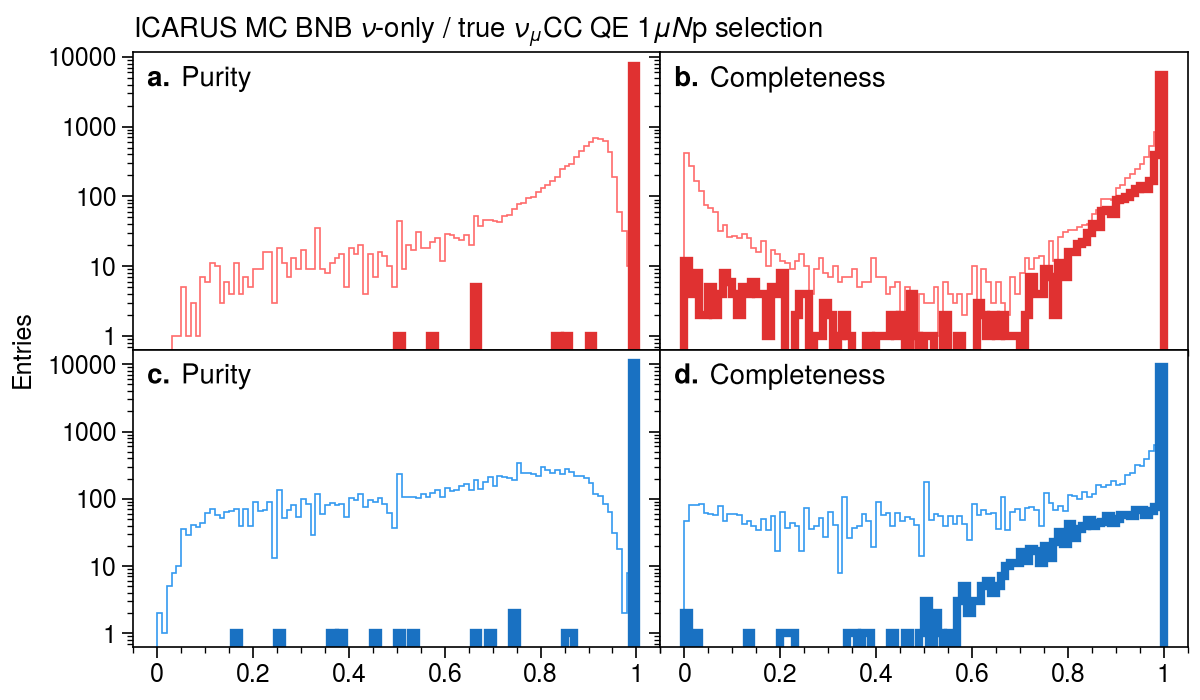

In [134]:
binning=hist.axis.Regular(100, 0, 1, flow=False)


fig, ax = plot.subplots(
    width=6, height=3.5, ncols=2, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ul',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

capitalise_title = {
    'purity': 'Purity',
    'completeness': 'Completeness'
}

# for axi, title in zip(ax, ['Purity', 'Completeness']*2):
#     axi.format(ultitle=title)

for idx, (loader, color) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'])):
    for jdx, var in enumerate(['purity', 'completeness']):

        (A,B), _ = loader.get(['nominal', 'cheated_2d_vtx_3d'], var, binning)
        A0, _ = loader.get('nominal', var, binning)
        B0, _ = loader.get('cheated_2d_vtx_3d', var, binning)

        hep.histplot(A0, ax=ax[idx,jdx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']}')
        hep.histplot(B0, yerr=False, ax=ax[idx,jdx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_2d_vtx_3d']}')
        ax[idx, jdx].format(ultitle=capitalise_title[var], xlabel='')

fig.savefig('plots_CCNp_test/toSlide_completeness_purity_3d.pdf', bbox_inches='tight')

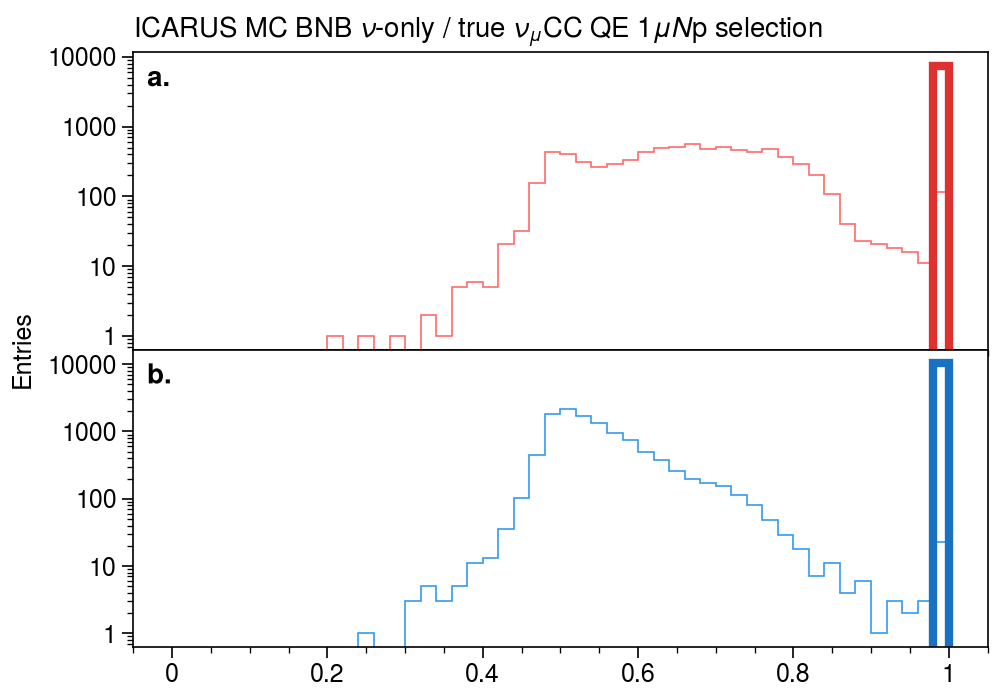

In [62]:


binning=hist.axis.Regular(50, 0, 1, flow=False)


fig, ax = plot.subplots(
    width=5, height=3.5, ncols=1, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ul',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

# for axi, title in zip(ax, ['Purity', 'Completeness']*2):
#     axi.format(ultitle=title)

for idx, (loader, color) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'])):

        (A,B), _ = loader.get(['nominal', 'cheated_mva'], 'trackScore', binning)
        A0, _ = loader.get('nominal', 'trackScore', binning)
        B0, _ = loader.get('cheated_2d_vtx_3d_nu_mva', 'trackScore', binning)

        hep.histplot(A0, ax=ax[idx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']}')
        hep.histplot(B0, yerr=False, ax=ax[idx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_mva']}')
        ax[idx].format(xlabel='')

fig.savefig('plots_CCNp_test/toSlide_BDT_trackscore.pdf', bbox_inches='tight')

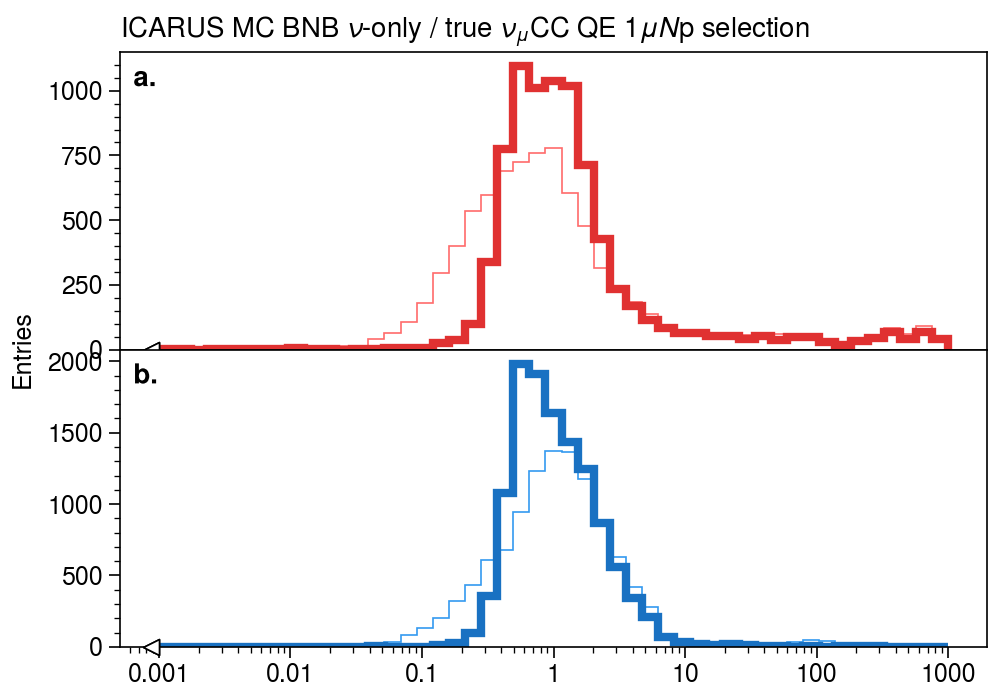

In [86]:
binning=hist.axis.Variable(np.logspace(-3, 3))


fig, ax = plot.subplots(
    width=5, height=3.5, ncols=1, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ul',
    # yscale='log',
    xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

var='vtxDist'

for idx, (loader, color) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'])):

        (A,B), _ = loader.get(['nominal', 'cheated_vtx'], var, binning)
        A0, _ = loader.get('nominal', var, binning)
        B0, _ = loader.get('cheated_vtx', var, binning)

        hep.histplot(A0, ax=ax[idx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']}')
        hep.histplot(B0, yerr=False, ax=ax[idx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_mva']}')
        ax[idx].format(xlabel='')


In [88]:
CCNp_vertex = Component(data=uproot.open('CCNp_vertexStudy.root:vertex'), tree_base='true_{}')
CCNp_vertex.keys('nominal')

['vtxDist_z', 'vtxDist_y', 'vtxDist_x', 'vtxDist', 'Run', 'Subrun', 'Evt']

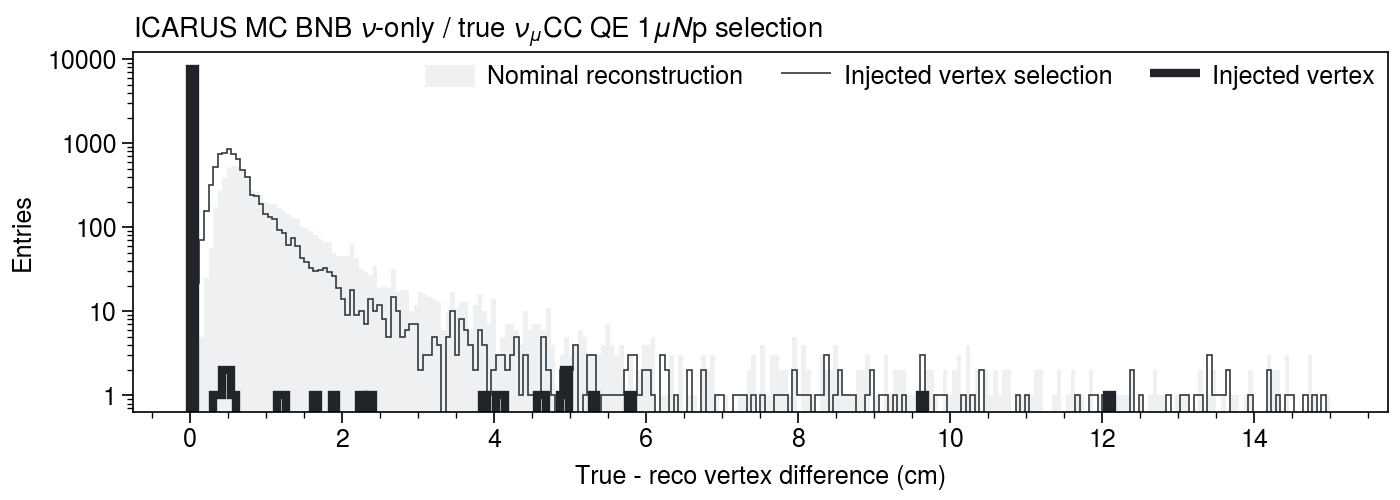

In [133]:


fig, ax = plot.subplots(
    width=7, height=2.5, ncols=1, nrows=1, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    # abc='a.', abcloc='ul',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', xlabel='True - reco vertex difference (cm)')

var='vtxDist'
binning=hist.axis.Regular(250, 0, 15, flow=False)

(A,B,C), _ = CCNp_vertex.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_vertex.get('nominal', var, binning)
B0, _ = CCNp_vertex.get('cheated_vtxSelection', var, binning)
C0, _ = CCNp_vertex.get('cheated_vtx', var, binning)

color='gray'

hep.histplot(A0, yerr=False, histtype='fill', alpha=0.5, color=f'{color}3', lw=2, ls=':', label=f'{loader_formatted['nominal']}')
hep.histplot(B0, yerr=False, color=f'{color}8', label=f'{loader_formatted['cheated_vtxSelection']}')
hep.histplot(C0, yerr=False, color=f'{color}9', lw=3, label=f'{loader_formatted['cheated_vtx']}')

ax.legend(loc='ur')
fig.savefig('plots_CCNp_test/toSlide_vertexStudy.pdf', bbox_inches='tight')
